# WhoSheLikes?

## Main purpose:

**To find whom targeted user likes in followings**

### Steps to do:

- Specify user

- Get all his followings

- Sort them by needed gender using prepared wordlist with male/female names

- Count likes by that user to everone in this group

- Draw bar graph of TOP 10 liked followings


### Login to your account

In [1]:
from InstagramAPI import InstagramAPI
import time, sys
from getpass import getpass

# Login to your account
login_result = None
while login_result != True:
    print("[!] Trying to login: ")
    username = input("[?] Enter your username: ")
    password = getpass("[?] Enter your password: ")

    insta = InstagramAPI(username, password)
    login_result = insta.login()

print("[+] Login success")


Fail to import moviepy. Need only for Video upload.
[!] Trying to login: 
[?] Enter your username: your_username
[?] Enter your password: ········
Request return 429 error!
{'message': 'Please wait a few minutes before you try again.', 'status': 'fail'}
Request return 404 error!
Login success!

[+] Login success


### Specify user to analyze

In [2]:
target = input("[?] Enter username to start analyzing followings: ")
target_info = insta.searchUsername(target)

while target_info != True:
    target = input("[!] Can't find this username. Try again: ") 
    target_info = insta.searchUsername(target)

print("[+] User was specified")

target_pk = insta.LastJson['user']['pk']

[?] Enter username to start analyzing followings: targeted_user
[+] User was specified


### Gather user's followings

In [3]:
# Get list of all needed Followings
following   = []
next_max_id = ""

while True:
        insta.getUserFollowings(target_pk, next_max_id)
        temp = insta.LastJson
        # generate list of all followings in dicts
        following.extend([{"name":item['full_name'], "pk":item['pk']} for item in temp['users']])
    
        if temp["big_list"] is False:
            break
        next_max_id = temp["next_max_id"]
        
print("[+] List of all followings is ready. Start to sorting using list of names")

[+] List of all followings is ready. Start to sorting using list of names


### Sort by specified namelist 

In [4]:

group_to_analyze = []
print("[!] Note we will scan a lot of users and if one has many followers and likes it will increase total scanning time")
max_allowed_followers = int(input("[?] How many followers per user is allowed: "))
print("[!] Note namelist file needs to be placed in same directory with this script or use absolute path" )
name_list = input("[?] Enter namelist file: ")


for user in following:
    
        full_name = [name.lower() for name in user['name'].split()]
        
        with open("male_names.txt", 'r', encoding='utf-8-sig') as file:
            for line in file.read().splitlines():
                
                # convert name from file to lowercase 
                # and check if either first name or last name equals
                match = any([ name == line.lower() for name in full_name])

                if match:
                    try:
                        insta.getUsernameInfo(user['pk'])
                        follower_count = insta.LastJson['user']['follower_count']
                        if follower_count < max_allowed_followers:
                            group_to_analyze.append({"name":user["name"], "pk": user["pk"], 'likes': 0, 'media_ids': []})
                            break
                    except KeyError:
                        break
   
if len(group_to_analyze) > 0:                
    print(f"[+] All followings were sorted. Total to scan: {len(group_to_analyze)}")
    #print(group_to_analyze)
else:
    print("[-] Failed to find anybody. Try to use another file with names")
    sys.exit(0)

[!]Note we will scan a lot of users and if one has many followers and likes it will increase total scanning time
[?] How many followers per user is allowed: 25000
[+] All followings were sorted. Total to scan: 26


### Function to gather all media by each user from sorted followings list

In [5]:
# same process to get media ids, need to paginate
def get_all_media(api, user_info, target):
    next_max_id = ""
    u_pk = user_info['pk']
    while True:
            try:     
                api.getUserFeed(usernameId=u_pk, maxid=next_max_id)

                # add media id to user's list in dict.
                user_info['media_ids'].extend([item['id'] for item in api.LastJson['items']])
                
                if api.LastJson['more_available'] is False:
                    break
                next_max_id = api.LastJson["next_max_id"]
                
            except KeyError:
                break
            # Sometimes Instagram sends corrupted JSON for no reason
            except ValueError:
                print("JSONDecodeError; skip", user_info['name'])
                break


### Function to count all likes for each user from that list by targeted user

In [6]:
def count_likes_by_target(api, media_id, user, target):
    #for id in user['media_ids']:
    try:
        api.getMediaLikers(media_id)
        all_likers = api.LastJson['users']
        for liker in all_likers:
            if liker['username'] == target:
                user['likes'] += 1
                break
    except KeyError:
        return
    except ValueError:
        return

In [7]:
def timer(start_time):
    final = time.time() - start_time
    hours = final // 3600
    minutes = final % 3600 // 60
    seconds = final % 60
    return f"\n[+] Finished in {hours}:{minutes}:{seconds}"    

### Start gathering users' media

In [8]:
start = time.time()
print("[!] Start adding media to analyze. This is time consuming part. Prepare yourself to wait...")

for user in group_to_analyze:
    get_all_media(insta, user, target)
    name = user['name']
    print(f"[*] {name} all media gathered")

print(timer(start))

[!] Start adding media to analyze. This is time consuming part. Prepare yourself to wait...
[*] username0 all media gathered
...
[+] Finished in 0.0:2.0:17.066662549972534


### Start counting likes by targeted user

In [9]:
print("[!] Start counting likes. This is time consuming part. Prepare yourself to wait...")
start = time.time()
for user in group_to_analyze:
    for id in user['media_ids']:
        count_likes_by_target(insta, id, user, target)
    print(f"[*] {user['name']} has {user['likes']} likes by {target}")
          
print(timer(start))

[!] Start counting likes. This is time consuming part. Prepare yourself to wait...
[*] username0 has 4
...

[+] Finished in 0.0:32.0:38.824299812316895


### Graphing part

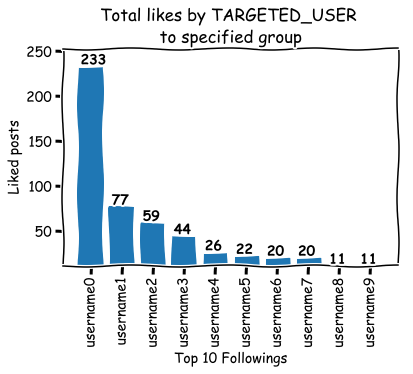

In [46]:
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
# sort list by number of likes in DESC order
group_to_analyze.sort(key=itemgetter('likes'), reverse=True)

# get coordinates for graph; top 10
y = list(map(itemgetter('likes'), group_to_analyze[:10]))
x = list(map(itemgetter('name'), group_to_analyze[:10]))
# x1 just for github; 
x1 = ['username' + str(i) for i in range(10)]

fig = plt.figure()

# xkcd styles
plt.xkcd()

# label x-axis with top followings names; x1 for github; for normal use change to x!
plt.xticks(np.arange(len(x)), x1, rotation='vertical')

# min and max values on y-axis
plt.ylim([min(y), max(y)+20])

# make a bar graph
plt.bar(np.arange(len(x)), y,)

# uncomment line below for normal use
# plt.title(f"Total likes by {target} \nto specified group")
# and delete this
plt.title(f"Total likes by TARGETED_USER \nto specified group")

plt.xlabel('Top 10 Followings')
plt.ylabel(f'Liked posts')

# label each bar with exact Y value
for x, value in enumerate(y):
    plt.text(x - 0.33, value + 2.5, str(value), color='black', fontweight='bold')

plt.show()
